# Toy Example of OWAD

In this note, I'll showcase the usage of **OWAD** and validate the effectiveness with a toy example.
To help you understand the basic idea, I'll use a synthetic dataset with a straightforward distribution.
Please note that the data distribution in a real-world case is much more complicated.

**(1) First, import packages:**

In [1]:
!wget https://raw.githubusercontent.com/figaz123/OWAD/main/admodels/DeepLog.py
!wget https://raw.githubusercontent.com/figaz123/OWAD/main/moudles/calibrator.py
!wget https://raw.githubusercontent.com/figaz123/OWAD/main/moudles/shifthunter.py
!wget https://raw.githubusercontent.com/figaz123/OWAD/main/myutils.py
!wget https://raw.githubusercontent.com/figaz123/OWAD/main/configs.yml
!wget https://raw.githubusercontent.com/dongtsi/OWAD/main/admodels/AE.py

--2024-03-29 04:36:22--  https://raw.githubusercontent.com/figaz123/OWAD/main/admodels/DeepLog.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5484 (5.4K) [text/plain]
Saving to: ‘DeepLog.py’

DeepLog.py          100%[===================>]   5.36K  --.-KB/s    in 0s      

2024-03-29 04:36:22 (82.5 MB/s) - ‘DeepLog.py’ saved [5484/5484]

--2024-03-29 04:36:22--  https://raw.githubusercontent.com/figaz123/OWAD/main/moudles/calibrator.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4332 (4.2K) [text/plain]
Saving to: ‘calibrat

In [2]:
%load_ext autoreload
%autoreload 2
## import packages
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../admodels/')
sys.path.append('../moudles/')
sys.path.append('../baselines/')
sys.path.append('../')
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import _pickle as pkl
import AE

## import OWAD moudles
from calibrator import Calibrator
from shifthunter import ShiftHunter
import myutils as utils

**(2) Next, generate data in form of clusters. To make sure that you understand some terms in our study, we clarify that the dataset during handling concept drift can be split into two sets:**
- *Control set*: this set of data represents the *old* distribution, or the distribution that the model can currently fit
- *Treatment set*: this set of data represents the *new* distribuion. Treatment set is sampled in the current environment and you want to know whether the new distribution is drifted compared with the old distribution

To finish the shift detection (and possible explanation and adaptation if concept drift), you have to collect partial data in treatment set and compared them with control set.

In this toy example, we simulate a kind of concept dirft. The control set consists of 3 clusters, two of them are not shifted/drifted in the treatment set, while the third one changes to another cluster of data.

See the following figure, two unchanged clusters are in black color, the *no longer existed* cluster (in treatment set) is in blue, the newly appeared cluster is in orange. The anomalies are in red.

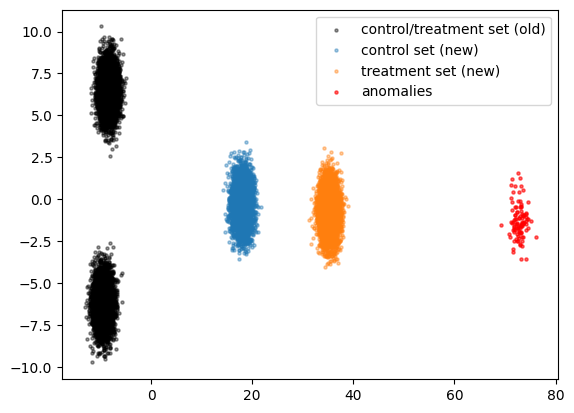

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi':100})

from sklearn.datasets import make_blobs

X_c_old, _ = make_blobs(n_samples=10000, centers=2, n_features=100,
                  random_state=42,center_box=(0,3),shuffle=False) # cluster_std=1.,

X_c_new, _ = make_blobs(n_samples=5000, centers=1, n_features=100,
                  random_state=300, center_box=(3,5), shuffle=False)

X_a, _ = make_blobs(n_samples=100, centers=1, n_features=100,
                  random_state=100, center_box=(8,12), ) # cluster_std=1., center_box=(6,7)

from sklearn.decomposition import PCA

X_c = np.concatenate((X_c_old, X_c_new))
pca = PCA(n_components=2, random_state=1).fit(X_c)
X_cp_old = pca.transform(X_c_old)
X_cp_new = pca.transform(X_c_new)

plt.scatter(X_cp_old[:, 0], X_cp_old[:, 1], alpha=0.4, c='black', s=5, label="control/treatment set (old)")
plt.scatter(X_cp_new[:, 0], X_cp_new[:, 1], alpha=0.4, s=5, label="control set (new)")

X_t_new, _ = make_blobs(n_samples=5000, centers=1, n_features=100,
                  random_state=0, center_box=(5,7), )

X_t = np.concatenate((X_c_old,X_t_new), axis=0)
X_tp = pca.transform(X_t)
X_tp_new = X_tp[10000:]

plt.scatter(X_tp_new[:, 0], X_tp_new[:, 1], alpha=0.4, s=5, label="treatment set (new)")

X_ap = pca.transform(X_a)
plt.scatter(X_ap[:, 0], X_ap[:, 1], color='red', alpha=0.6, s=5, label="anomalies")

plt.legend()
plt.show()


**(3) Now let's assume we're at the very beginning. We only have the control set data and want to train an anomaly detection model.**

Here we train an autoencoder with normal data (we assume the control set and treatment set are all normal data).
Btw, the training procedure is to minimize the reconstruction error.

In [4]:
utils.set_random_seed()
X_train = X_c
model, thres = AE.train(X_train, X_train.shape[-1], lr=1e-3)

epoch:0/10 |Loss: 7.488219738006592
epoch:1/10 |Loss: 2.4467079639434814
epoch:2/10 |Loss: 1.618299961090088
epoch:3/10 |Loss: 1.5097343921661377
epoch:4/10 |Loss: 1.4773900508880615
epoch:5/10 |Loss: 1.4634264707565308
epoch:6/10 |Loss: 1.4483004808425903
epoch:7/10 |Loss: 1.443068504333496
epoch:8/10 |Loss: 1.452040672302246
epoch:9/10 |Loss: 1.4252067804336548
max AD score 1.5375081
thres: 1.4419969


**(4) Let's test the performance of our anomaly model in the control set (i.i.d. setting).**

TPR>99%, FPR<1% AUC>99%, Seems great aha!

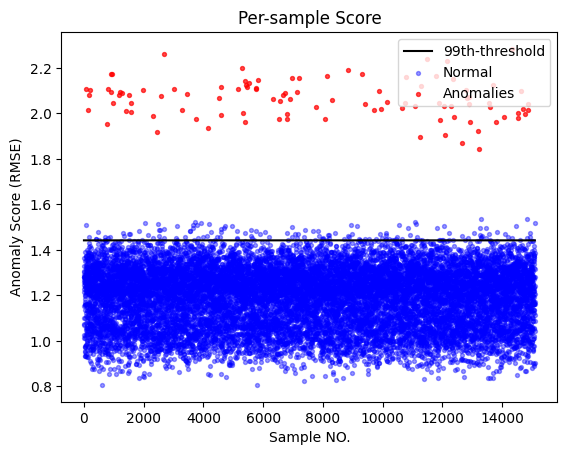

TPR: 0.999999999999 FPR: 0.009999999999999933
roc_auc: 0.9900000000000001


In [5]:
from sklearn.utils import shuffle
X_con_test = np.concatenate((X_c,X_a))
y_con_test = np.asarray([0]*15000+[1]*100)
X_con_test, y_con_test = shuffle(X_con_test, y_con_test)

pred_c, rmse_c = AE.test(model, thres, X_con_test)
AE.test_plot(rmse_c, thres, label=y_con_test)
utils.TPR_FPR(rmse_c, y_con_test, thres)
utils.multi_metrics(rmse_c, y_con_test, thres, plot_file=None)

**(5）Suppose after a period of time, we want to see if concept drift has occurred, we have collected some data now (exactly treatment set), let's see how the model works on the treatment set data.**

FPR > 22% AUC falls to 77% That's not good /(ㄒoㄒ)/~~

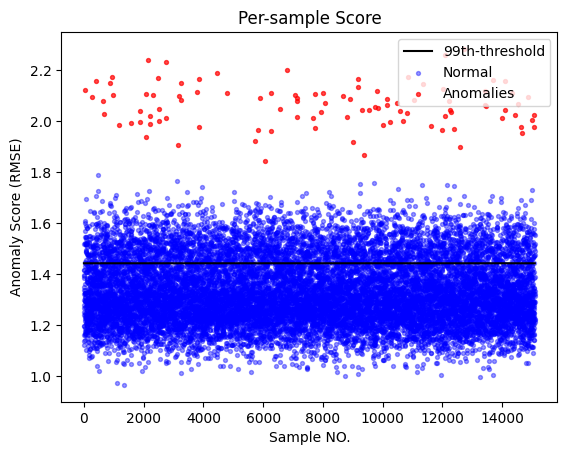

TPR: 0.999999999999 FPR: 0.22233333333333186
roc_auc: 0.7776666666666666


In [6]:
X_tre_test = np.concatenate((X_t,X_a))
y_tre_test = np.asarray([0]*15000+[1]*100)
X_tre_test, y_tre_test = shuffle(X_tre_test, y_tre_test)

pred_t, rmse_t = AE.test(model, thres, X_tre_test)
AE.test_plot(rmse_t, thres, label=y_tre_test)
utils.TPR_FPR(rmse_t, y_tre_test, thres)
utils.multi_metrics(rmse_t, y_tre_test, thres, plot_file=None)

## Time to let OWAD shine!
**(6) Let's first check whether distribution shift (concept drift) happens technically. You may think that the model perforemance degradation in the above experiment has verified the concept drift. That's right! However, there are two limitations of observing model performance to determine concept drift: the first is the observation requires labelling and the second is some drift does not necessarily affect the performance of the model. Therefore, OWAD uses a distributional hypothesis test. In short, you can get a confidence score (p-value) to determine whether shift or not.
The smaller the p-value, the greater the probability of drift (common practice of threshold is 0.01 or 0.05).**

P-value is so small, we fully believe that drift has occurred!
We also visualize how data distribution shifts from control set to treatment set.

NOTICE: Initialize OWAD Calibrator Under **Isotonic** Method!
NOTICE: uncalibrated Probs is **MALICIOUS** confidence
NOTICE: Initilize OWAD Shift Handler Under **Tab** Mode!
Shift! P-value is 0.000999000999000999
Visualize Shift:


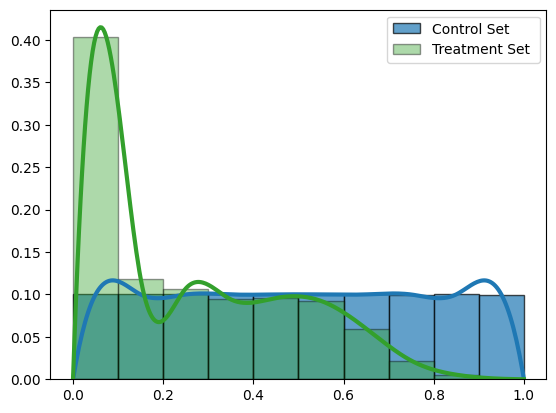

In [7]:
X_con, y_con = X_c, np.asarray([0]*15000)
X_tre, y_tre = X_t[::3], np.asarray([0]*5000)
_, rmse_c = AE.test(model, thres, X_con)
_, rmse_t = AE.test(model, thres, X_tre)

utils.set_random_seed()
cb = Calibrator(X_con, method='Isotonic')
cb.set_calibrator(rmse_c, is_P_mal=True)
sh = ShiftHunter(rmse_c, rmse_t, cb, ad_type='Tab')
t = utils.get_params('ShiftDetector')['test_thres']
p_value = sh.permu_test()
if p_value >= t:
    print("Non-shift, skip explain and adaptation!")
else:
    print('Shift! P-value is', p_value)
print("Visualize Shift:")
sh.visualize_hists()

**(7.1) Because the drift has occurred, we want to explain the drift, that is, we want to see which samples caused the drift. The  explaination of OWAD is a procedure to find more influential samples (for causing the drift) and at the same time we want to find less such samples to reduce labeling overhead (see the further step of shift adaptation, we need to label such samples before use them to retrain the model)**

This procedure is to solve an optimization problem. We omit technical details here. The following figures show the error between explanation set the treatment set, as well as the components of explanation set.

step:0 |Loss:21.0000 |Accuracy_Loss:1.0000 |Overhead_Loss:1.0000 |Determinism_Loss:1.0000 |M_c num: 7500 |M_t num: 2744
step:10 |Loss:17.0363 |Accuracy_Loss:0.7288 |Overhead_Loss:1.0252 |Determinism_Loss:0.9778 |M_c num: 7678 |M_t num: 2854
step:20 |Loss:14.9931 |Accuracy_Loss:0.5866 |Overhead_Loss:1.0511 |Determinism_Loss:0.9391 |M_c num: 8010 |M_t num: 2876
step:30 |Loss:13.6101 |Accuracy_Loss:0.4896 |Overhead_Loss:1.0749 |Determinism_Loss:0.8924 |M_c num: 8444 |M_t num: 2836
step:40 |Loss:12.7347 |Accuracy_Loss:0.4292 |Overhead_Loss:1.0875 |Determinism_Loss:0.8592 |M_c num: 8916 |M_t num: 2627
step:50 |Loss:11.8544 |Accuracy_Loss:0.3685 |Overhead_Loss:1.1020 |Determinism_Loss:0.8163 |M_c num: 9521 |M_t num: 2334
step:60 |Loss:11.0583 |Accuracy_Loss:0.3148 |Overhead_Loss:1.1116 |Determinism_Loss:0.7778 |M_c num: 9931 |M_t num: 2031
step:70 |Loss:10.0827 |Accuracy_Loss:0.2488 |Overhead_Loss:1.1250 |Determinism_Loss:0.7259 |M_c num: 10310 |M_t num: 1732
step:80 |Loss:9.4556 |Accuracy_L

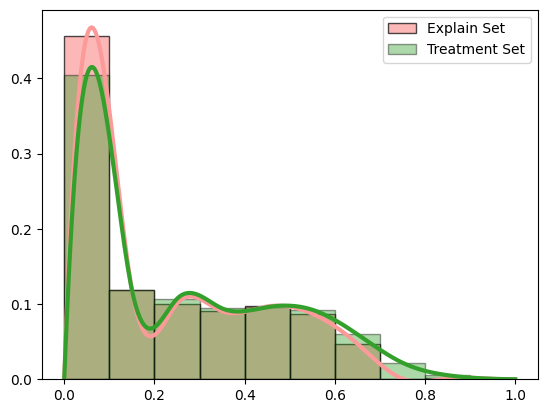

** Warning: No Need to Clip <remain_X_t> according to <label_num>
   (label_num:2000, remain_X_t:1312, X_t:5000)
NOTICE: simulating labelling...
Filter 0 anomalies in remain_X_tre
Remain X_c.shape (3875, 100) X_t.shape (1312, 100)


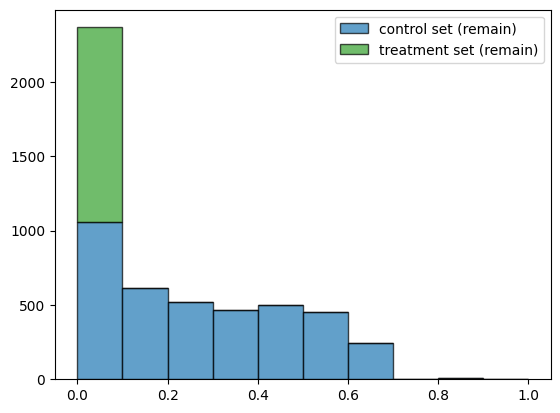

In [8]:
utils.set_random_seed()
ohd_bgt = 2000
exp_result = sh.explainer(X_tre, y_tre, label_num = ohd_bgt,
                            lr=5., steps=100, plot_compose=True,
                            acc_wgt = 15, ohd_wgt = 5, det_wgt = 1,)

**(7.2) Let's validate the effectiveness of OWAD explanation. The explanation result can be like "some samples in control set *remain* normal, some samples in the control set are *no-longer* normal, some samples in treatment set *newly become* normal". In this simple example, we have a God's perspective: we know that the drift drifts because one cluster disappears, and the other cluster appears, let's check if owad can find this.**

See the following figure, 1197 samples of new cluster data is selected and the old (disappeared) cluster only has 100 samples left, and the old (remaining) two clusters are with 1825 and 1981 samples.
This indicates OWAD explanation correctly explains the shift in the distribution!

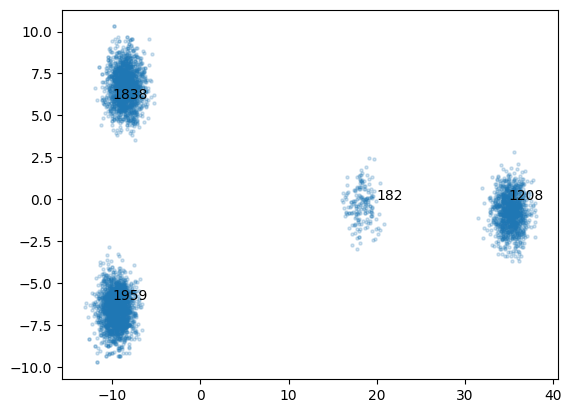

In [9]:
# exp_result

X_exp = np.concatenate((exp_result['remain_X_con'], exp_result['remain_X_tre']))
X_expp = pca.transform(X_exp)

count = [0,0,0,0]
for x in X_expp:
    if  x[0]<0 and x[1]<0:
        count[0] += 1
    elif  x[0]<0 and x[1]>0:
        count[1] += 1
    elif x[0]<25:
        count[2] += 1
    elif x[0]<40:
        count[3] += 1

plt.scatter(X_expp[:, 0], X_expp[:, 1], alpha=0.2, s=5, label="exp_set")
plt.text(-10,-6, str(count[0]))
plt.text(-10,6, str(count[1]))
plt.text(20,0, str(count[2]))
plt.text(35,0, str(count[3]))
plt.show()

**(8) Now, the last but the most important step is to remedy our poor model. As mentioned above, we retrain the model with samples in the explanation set and test the performance in the treatment set after adapation. We also leverage some techniques to prevent forgetting useful knowledge of model during retraining.**

After adaptation, FPR reduce from 22% to 2%! AUC increase from 77% to 97%. Nice job, OWAD!  

Adapter: Begin Processing ... 
 Estimating Params Weight:0/519
epoch:0 ,step:0 |Distrib_Loss:1.8272 rmse_vec:1.3463
epoch:1 ,step:0 |Distrib_Loss:1.8267 rmse_vec:1.3431
epoch:2 ,step:0 |Distrib_Loss:1.8064 rmse_vec:1.3401
epoch:3 ,step:0 |Distrib_Loss:1.8105 rmse_vec:1.3374
epoch:4 ,step:0 |Distrib_Loss:1.7929 rmse_vec:1.3347
epoch:5 ,step:0 |Distrib_Loss:1.7853 rmse_vec:1.3320
epoch:6 ,step:0 |Distrib_Loss:1.7754 rmse_vec:1.3296
epoch:7 ,step:0 |Distrib_Loss:1.7586 rmse_vec:1.3272
epoch:8 ,step:0 |Distrib_Loss:1.7610 rmse_vec:1.3249
epoch:9 ,step:0 |Distrib_Loss:1.7468 rmse_vec:1.3226
epoch:10 ,step:0 |Distrib_Loss:1.7429 rmse_vec:1.3204
epoch:11 ,step:0 |Distrib_Loss:1.7476 rmse_vec:1.3184
epoch:12 ,step:0 |Distrib_Loss:1.7469 rmse_vec:1.3165
epoch:13 ,step:0 |Distrib_Loss:1.7309 rmse_vec:1.3146
epoch:14 ,step:0 |Distrib_Loss:1.7342 rmse_vec:1.3127
epoch:15 ,step:0 |Distrib_Loss:1.7345 rmse_vec:1.3109
epoch:16 ,step:0 |Distrib_Loss:1.7139 rmse_vec:1.3092
epoch:17 ,step:0 |Distrib_Los

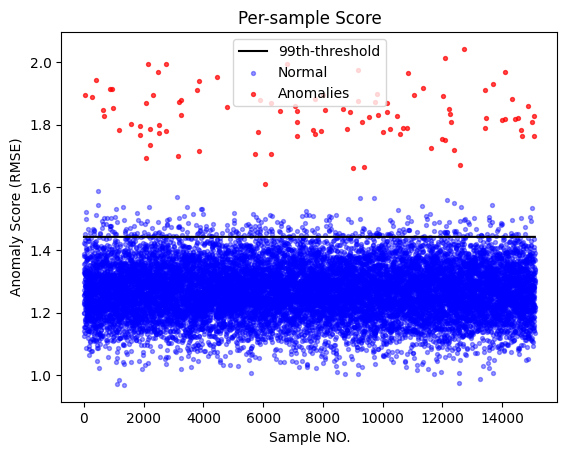

TPR: 0.999999999999 FPR: 0.02166666666666652
roc_auc: 0.9783333333333334


In [10]:
sh.adapter(model,lr=1e-3, steps=20)
y_pred, y_prob = AE.test(sh.model, thres, X_tre_test)
AE.test_plot(y_prob, thres, label=y_tre_test)
utils.TPR_FPR(y_prob, y_tre_test, thres)
utils.multi_metrics(y_prob, y_tre_test, thres, plot_file=None)

**(9) At last, I also want to highlight the motivation and advantages of OWAD compared to *direct retraining*, which is a common practice before OWAD. We retaining a new model with a combination of control set and treatment set, and evaluate the performance on the treatment set. As you can see in the following figure. The performance is quite poor (no effect cpmpared with baseline). This is because direct retraining does not account for changes in the distribution of the data. Specficially in this toy example, it cannot *forget* the old cluster that no longer occurs in the new distribution.**

epoch:0/20 |Loss: 6.358801364898682
epoch:1/20 |Loss: 1.710580587387085
epoch:2/20 |Loss: 1.5465683937072754
epoch:3/20 |Loss: 1.5051552057266235
epoch:4/20 |Loss: 1.4772909879684448
epoch:5/20 |Loss: 1.4742788076400757
epoch:6/20 |Loss: 1.4814667701721191
epoch:7/20 |Loss: 1.4590966701507568
epoch:8/20 |Loss: 1.441710352897644
epoch:9/20 |Loss: 1.4277302026748657
epoch:10/20 |Loss: 1.400791049003601
epoch:11/20 |Loss: 1.3257263898849487
epoch:12/20 |Loss: 1.2850067615509033
epoch:13/20 |Loss: 1.2640715837478638
epoch:14/20 |Loss: 1.2613272666931152
epoch:15/20 |Loss: 1.243544340133667
epoch:16/20 |Loss: 1.2227606773376465
epoch:17/20 |Loss: 1.1730990409851074
epoch:18/20 |Loss: 1.1099638938903809
epoch:19/20 |Loss: 1.0100696086883545
max AD score 1.3010601
thres: 1.1773634
After Retraining:


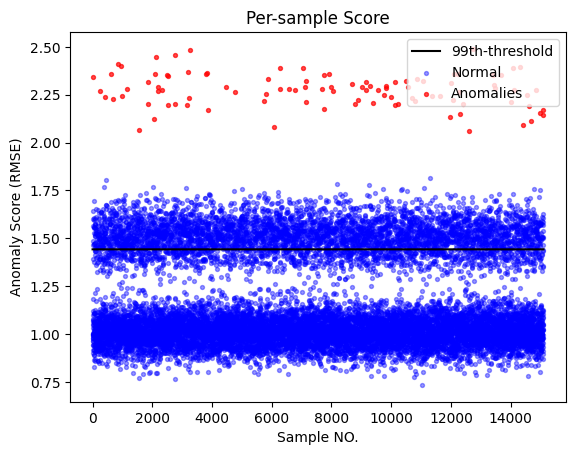

TPR: 0.999999999999 FPR: 0.25673333333333165
roc_auc: 0.7432666666666666


In [11]:
utils.set_random_seed()
X_retrain = np.concatenate((X_con,X_tre[:ohd_bgt]))
retrain_model, retrain_thres = AE.train(X_retrain, X_retrain.shape[-1], epoches=20, lr=1e-3)

## test the performance of retraining model
print('After Retraining:')
y_pred, y_prob = AE.test(retrain_model, thres, X_tre_test)
AE.test_plot(y_prob, thres, label=y_tre_test)
utils.TPR_FPR(y_prob, y_tre_test, thres)
utils.multi_metrics(y_prob, y_tre_test, thres, plot_file=None)